# Self Practice 1: Single Layer Perceptron using Numpy

© Machine Learning Summer School - Telkom University

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%201/MLSS2020TU%20-%20Self%20Practice%201.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
    
</td><td>
<a href="https://github.com/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%201/MLSS2020TU%20-%20Self%20Practice%201.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>



In this exercise you will practice putting together a simple image classification pipeline, based on Neural Network classifier. 

The goals of this assignment are as follows:

1. understand the basic Binary Classification pipeline
1. implement and apply standard Artificial Neuron function






# [Part 0] Preparation



## 1 - Import Libraries

In [1]:
import numpy as np

from PIL import Image
import cv2 as cv
import h5py    

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=7)


## 2 - Helper Functions

In [2]:
def load_dataset():
    !wget -q 'https://raw.githubusercontent.com/CNN-ADF/Task2019/master/resources/catvnoncat.h5'
    dataset = h5py.File('catvnoncat.h5', "r")
    print('dataset downloaded')

    train_set_x_orig = np.array(dataset["X_train"][:]) # your train set features
    train_set_y_orig = np.array(dataset["y_train"][:]) # your train set labels
    val_set_x_orig = np.array(dataset["X_val"][:]) # your val set features
    val_set_y_orig = np.array(dataset["y_val"][:]) # your val set labels
    classes = np.array(dataset["classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, val_set_x_orig, val_set_y_orig, classes

In [3]:
def open_image(filename, show=True):
    image = Image.open(filename)
    image = np.array(image)
    if show:
        plt.imshow(image)
        plt.show
    return image

In [4]:
def resize_image(image, shape=(64,64), show=True):
    new_image = cv.resize(image, shape, interpolation=cv.INTER_AREA)
    if show:
        plt.imshow(new_image)
        plt.show()
    return new_image

# [Part 1] Binary Classification Problem

For this exercise, we will use binary class data to recognize `cats` and `not cats`. The images are $64\times64$ in dimension.

Since this is a binary classification problem, so we can use the **binary cross-entropy** loss function to measure how good the model's predictions are.
For that we use the **sigmoid** activation function

## 1 - Load And Normalize Dataset




first, load the dataset


In [5]:
X_train_ori, y_train, X_val_ori, y_val, classes = load_dataset()

dataset downloaded


Now let's take a look at the data

In [6]:
print(X_train_ori.shape)
print(y_train.shape)
print(X_val_ori.shape)
print(y_val.shape)

(209, 64, 64, 3)
(209, 1)
(50, 64, 64, 3)
(50, 1)


View some data

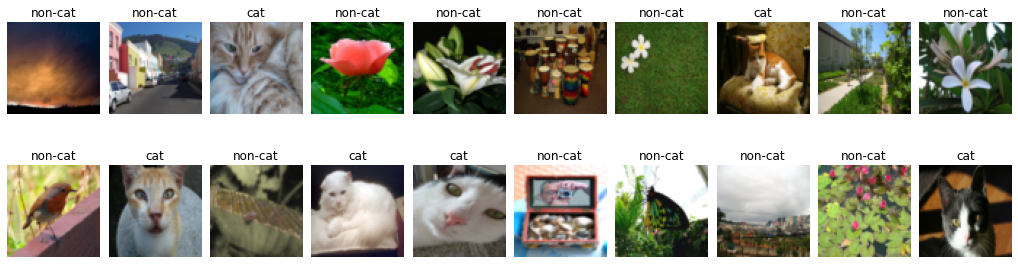

In [7]:
fig, ax = plt.subplots(2,10,figsize=(18,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train_ori[i+j*10])
        ax[j,i].set_title(classes[y_train[i+j*10,0]].decode("utf-8") )
        ax[j,i].axis('off')
plt.show()

then reshape the original data into 1-dimensional matrix, and store them as  `X_train` and `X_val`

In [8]:
X_train = X_train_ori.reshape(X_train_ori.shape[0], -1)
X_val = X_val_ori.reshape(X_val_ori.shape[0], -1)

lastly, since for this dataset we're using sigmoid, standarize the dataset into a `range of 0-1` by dividing it with `255`

In [9]:
X_train = X_train/ 255.
X_val = X_val/255.

---
## 2 - Artificial Neurons

Standard Artificial Neuron is basically a linear transformation function that receive vector input `x` and weight matrix `W`, and usually followed with a bias `b`. The output of an Artificial Neuron is defined as follow:

$$
\begin{align}
f(x, W, b) = x.W + b
\end{align}
$$


> in Mathematics, this function also known as Affine Function


As you know, the purpose of machine learning is to automatically adjust the values of weight matrices to find a suitable decision boundary.

This is where optimisation by **Gradient Descent** through **Backpropagation** comes in. The idea is that for each (batch of) data points, we compute the loss using the current values of the weights on the data. We then compute the gradient (or derivative) of the loss function at the current weight values.

For that we need to define the backward (derivative) function for the Artificial Neuron as follow:

$$
\begin{align*}
\partial W & = x^T.\partial out \\
\partial b & = \sum \partial out \\
\partial x & = \partial out.W^T \\
\end{align*}
$$

Now we're going to implement those functions

---
### a. Forward Affine Function


> <font color='red'>**EXERCISE**: </font> implement forward pass for Affine layer



In [10]:
def affine_forward(x, W, b):  
  
    v = x.dot(W) + b            # x dot W + b  
    
    return v

---
### b. Backward Affine Function


> <font color='red'>**EXERCISE**: </font> implement backward pass for Affine layer



In [11]:
def affine_backward(dout, x, W, b):
  
    dW = x.T.dot(dout)           # x.T dot dout
    db = np.sum(dout, axis=0, keepdims=True)           # sum dout, axis=0, keepdims=True
    dx = dout.dot(W.T)           # dout dot W.T
    
    return dW, db, dx

---
## 3 - Binary Cross-Entropy


For this classification problem, we consider the **binary cross-entropy** loss function to measure how good the model's predictions are.  This loss function compares the model's prediction for each example, $\mathbf{x_i}$ to the true **target** $y_i$ (we often refer to the true label associated with an input as the "target"). It then applies the non-linear log function to penalise the model for being further from the true class.


The equation for the binary cross entropy loss, on a dataset with $N$ points is defined as follows:

\begin{align}
l(\mathbf{w}; \mathbf{\hat{y}}, \mathbf{y}) = -\frac{1}{N}\sum_{i=1}^N y_i log(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)
\end{align}

where $\hat{y}_i = \operatorname{sigmoid}(\mathbf{w}^T\mathbf{x_i})$



In [12]:
def binary_cross_entropy_loss(predictions, targets, epsilon=+1e-10):

    # Compute the local loss term
    N = predictions.shape[0]

    # We add 1e-10 to make the log operations numerically stable (i.e. avoid taking the log of 0.)
    log_likelihood = targets * np.log(predictions+epsilon) + (1.-targets)*np.log(1.-predictions+epsilon)
    loss = -np.sum(log_likelihood)/N
    
    return loss


---
## 4 - Sigmoid Function

The binary cross entropy function uses an operation called a  $\operatorname{sigmoid}$ function. This functions allows our classifier to output any real value. The binary cross entropy loss function, however, expects the predictions made by a classifier to be between $0$ and $1$. The sigmoid function "squashes" any real number inputs to lie in the interval $(0, 1)$.

The sigmoid function itself is defined as:

$$
\begin{align}
f(x) = \sigma(x) = \frac{1}{1+e^{-v}}
\end{align}
$$


### a. Forward Sigmoid Function

> <font color='red'>**EXERCISE**: </font>implement forward pass for sigmoid activation function



In [13]:
def sigmoid_forward(x):  
  
    out = 1/(1 + np.exp(-x))  # 1 / ( 1 + exp (-x) )

    return out

---
## 5 - One-Layer Sigmoid

We'll train a Single Layer Perceptron with Sigmoid for binary Classification using Full batch **Gradient Descent**



### a. Training Function
> <font color='red'>**EXERCISE:** </font> Implement Training Function

* call affine forward function
* call sigmoid forward function
* call binary cross-entropy loss function
* call affine backward function
* implement weight update
* The network architecture should be: <br>
><pre><font color="blue"><b>Input - FC layer - Sigmoid</b></font></pre>



In [14]:
def train_one_layer(X, y, W=None, b=None, lr=0.005, epochs=100, verbose=True):
        
    num_train, dim = X.shape
    
    num_classes = 1
    
    # initialize weights if not provided
    if W is None:
        W = 0.02*np.random.rand(dim, num_classes)
    if b is None:
        b = np.zeros((1, num_classes))

    # Run stochastic gradient descent to optimize W
    loss_history = []
                     
    for ep in range(epochs):
        

        # calculate 1st layer score by calling affine forward function using X, W, and b as input
        layer1 = affine_forward(X, W, b)
        
        # calculate 1st activation score by calling sigmoid forward function using layer1 score as input
        act1 = sigmoid_forward(layer1)
        
        # calculate error by subtracting act1 with y
        error = act1 - y
        
        # calculate loss by calling binary cross entropy loss function using act1 and y as input 
        loss = binary_cross_entropy_loss(act1, y)
        
        # divide error by num_train    
        error /= num_train
    
        # calculate layer 1 weights gradient by calling affine backward function using error, X, W, and b as input
        dW, db, _ = affine_backward(error, X, W, b)

        
        # perform parameter update by subtracting each W and b with a fraction of dW and db
        # according to the learning rate
        W -= lr * dW
        b -= lr * db

        if verbose and ep % 100 == 0:
            print ('epoch',ep,'/',epochs, ': loss =', loss)
            
            # append the loss history
            loss_history.append(loss)

    print('Training done')
    
    return W, b, loss_history

### b. Train the Binary Classifier

Try the training Function using the initial parameter

In [15]:
W, b, loss = train_one_layer(X_train, y_train, epochs=1000, lr=0.005)

epoch 0 / 1000 : loss = 14.86468521942311
epoch 100 / 1000 : loss = 0.6357241314242678
epoch 200 / 1000 : loss = 0.47920090951280003
epoch 300 / 1000 : loss = 0.3745581219198142
epoch 400 / 1000 : loss = 0.3314062215443392
epoch 500 / 1000 : loss = 0.30350538956588413
epoch 600 / 1000 : loss = 0.28027137652696266
epoch 700 / 1000 : loss = 0.26052050120351283
epoch 800 / 1000 : loss = 0.2434622966412321
epoch 900 / 1000 : loss = 0.2285424989780635
Training done


Visualize the loss

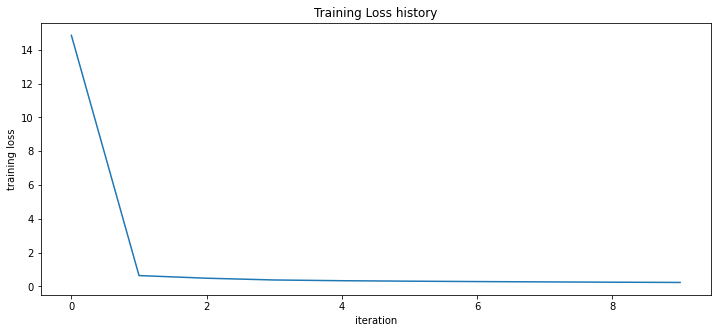

In [16]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(loss)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


### c. Predict Function


In [17]:
def predict_one_layer(X, W, b):    
    y_pred = np.zeros(X.shape[1])
    
    # calculate 1st layer score by calling affine forward function using X, W, and b
    layer1 = affine_forward(X, W, b)

    # calculate 1st activation score by calling sigmoid forward function using layer1 score
    act1 = sigmoid_forward(layer1)
    
    # since it's a binary class, round the score to get the class
    y_pred = np.round(act1)
    
    return y_pred.astype('int')

### d. Training Accuracy
Calculate the Training Accuracy

In [18]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_one_layer(X_train, W, b)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15].ravel())
print('Predicted label =',y_pred[:15].astype('int').ravel())

Training Accuracy = 97.1291866028708 %
Training label  = [0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]
Predicted label = [0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]


**EXPECTED OUTPUT**:

<pre>You should get about <b>~97%</b> accuracy on training set using the initial run</pre>

Calculate the Validation Accuracy

In [19]:
y_pred = predict_one_layer(X_val, W, b)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15].ravel())
print('Predicted label  =',y_pred[:15].astype('int').ravel())

Validation Accuracy = 72.0 %
Validation label = [1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Predicted label  = [1 1 1 1 1 1 0 1 1 1 0 0 1 1 0]


**EXPECTED OUTPUT**:

<pre>You should get about <b>~72%</b> accuracy on validation set</pre>

<br>

You can continue further training the weights by adding the pre-trained W and b to the arguments when calling training function



In [20]:
# loss, W, b = train_one_layer(X_train, y_train, W=W, b=b, num_iters=1000, learning_rate=0.005)

---
## 6 - Test on New Image

Lastly, we can use the trained weigths to try and classify images from the Internet

### a. Load Image

First, we download some images from the Internet

In [21]:
!wget -q -O 'cat.jpg'    'https://p0.pikist.com/photos/593/949/domestic-cat-head-animal-portrait-attention-close-up-cat-cat-face.jpg'
!wget -q -O 'no_cat.jpg' 'https://cutewallpaper.org/21/cute-wallpapers-dogs/Dog-Wallpapers-Pictures-Cute-Dogs-by-Fexy-Apps.jpg'

let's view the images

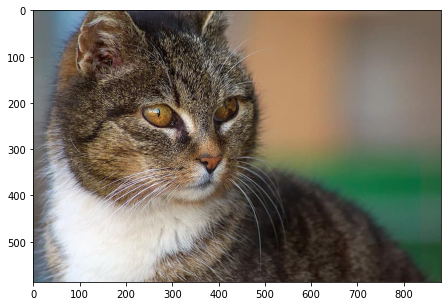

In [22]:
im1 = open_image('cat.jpg')

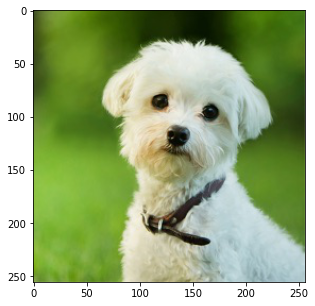

In [23]:
im2 = open_image('no_cat.jpg')

### b. Resize and Normalize Image

Since we trained the weights using normalized $64\times64$ images, it means that we need to also resize and normalize the new images

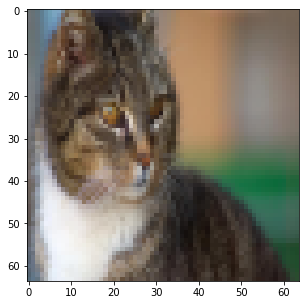

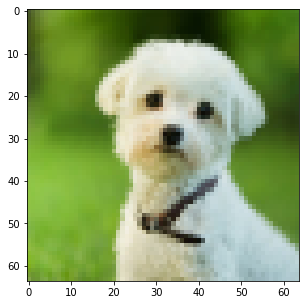

In [24]:
im1 = resize_image(im1)
im2 = resize_image(im2)

In [25]:
im1_n = im1/255.
im2_n = im2/255.


### c. View Prediction

Now let's feed the new data into the model, and show the predicted label

In [26]:
new_data = np.array([im1_n,im2_n]).reshape(2,-1)

y_pred = predict_one_layer(new_data, W, b)

print('predicted class:')
print(y_pred)

predicted class:
[[1]
 [0]]


In [27]:
print('predicted label:')
print(classes[y_pred])

predicted label:
[[b'cat']
 [b'non-cat']]


---

# Congratulation

<font size=5> You've Completed Self Practice 1</font>

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>